In [1]:
import numpy as np
import pandas as pd
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

from ABC_MC import *
from model_classes import *

In [2]:
from ABC_MC import log_fact

### The first thing that is interesting to see is the value of the BF as a function of the quantile used for inference. 

In [3]:
# generate dataset
dataset = np.random.poisson(0.5, 100)  # use a Poisson(0.5)
true_BF(dataset)

16.7683721494293

In [4]:
n_samples = 100
n_sim = 30000
models = (PoissonModel, GeometricModel)
quantile = 0.05
reference_statistics = compute_reference_statistics(dataset)

In [5]:
%%time 

# generate the reference table (expensive step - do it only once)
res = ABC_MC(models, n_samples, n_sim)

CPU times: user 1min 16s, sys: 51.3 ms, total: 1min 16s
Wall time: 1min 17s


Set the quantiles for which you want to have the plot

In [6]:
quantiles = np.arange(0.001, 0.1, 0.0005)

In [7]:
appr_BFs = np.zeros(len(quantiles))

for i, quantile in enumerate(quantiles): 

    res_filtered = select_relevant_simulations(res, reference_statistics, quantile=quantile, 
                                               use_all_statistics=True)

    try:
        BF = sum(res_filtered["model"]==0)/sum(res_filtered["model"]==1)
    except: 
        BF = np.infty

    appr_BFs[i] = BF

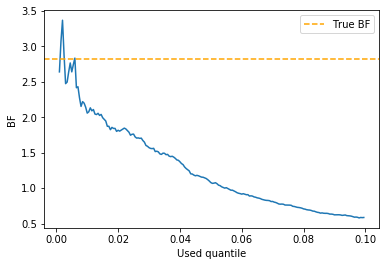

In [8]:
plt.plot(quantiles, np.log(appr_BFs))
plt.axhline(np.log(true_BF(dataset)), ls="--", label="True BF", color="orange")

plt.xlabel("Used quantile")
plt.ylabel("BF")
plt.legend()
plt.show()

## I can generate a single reference table (the expensive step) and simply use it to estimate the BF of all the observed datasets. 

In [9]:
n_sim = 30000
models = (PoissonModel, GeometricModel)

In [10]:
%%time 

# generate the reference table (expensive step - do it only once)
res = ABC_MC(models, n_samples, n_sim)

CPU times: user 1min 15s, sys: 69.2 ms, total: 1min 15s
Wall time: 1min 16s



## Extract 1000 datasets with $n=100$ uniformly covering the range of $\frac{P(\mathcal M = 1|\boldsymbol{y})}{P(\mathcal M = 2|\boldsymbol{y})+ P(\mathcal M = 1|\boldsymbol{y})}$ between 0.01 and 0.99. 
The implementation of this should be done using rejection sampling.

In [11]:
%%time
# first, generate a big number of datasets, to estimate the distribution of the BF/(1 + BF)

n_samples = 100
n_datasets = 20000

trial_datasets = np.random.poisson(0.5, (n_datasets, n_samples))

trial_datasets_summary = pd.DataFrame(columns=("s_1", "t_1", "trueBF", "appr_BF_all_stats", "appr_BF_1_stat"))

for i in range(n_datasets): 
    stats = compute_reference_statistics(trial_datasets[i])
    trial_datasets_summary.loc[i] = [stats["s_1"], stats["t_1"], true_BF(trial_datasets[i]), None, None]
    
    

CPU times: user 1min 15s, sys: 21.6 ms, total: 1min 16s
Wall time: 1min 16s


Exclude the datasets for which $BF/(1 + BF) \notin [0.01, 0.99] \iff BF \notin [0.0101, 98.9999] $

In [12]:
lim_inf = (0.01/ 0.99)
lim_sup = (0.01/ 0.99)**(-1)

In [13]:
trial_datasets_summary_cleaned = trial_datasets_summary[(trial_datasets_summary["trueBF"] > lim_inf) & 
                                                        (trial_datasets_summary["trueBF"] < lim_sup)]

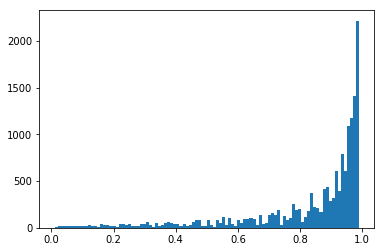

In [14]:
n, bins, _ = plt.hist(
    trial_datasets_summary_cleaned["trueBF"]/(trial_datasets_summary_cleaned["trueBF"] + 1), bins = 100)

Now, for every bin we take 10 elements. In this way they will be approximately uniformly distributed. It is not very rigorous but it's not an important step.

In [15]:
trial_datasets_summary_cleaned["odds"] = trial_datasets_summary_cleaned["trueBF"]/(trial_datasets_summary_cleaned["trueBF"] + 1)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
target_n_datasets = 1000
n_elem_from_each_bin = target_n_datasets//(len(bins) - 1)

final_datasets = pd.DataFrame()

for i in range(len(bins) - 1): 
    trial_datasets_bin = \
    trial_datasets_summary_cleaned[(trial_datasets_summary_cleaned["odds"] > bins[i]) & 
                                   (trial_datasets_summary_cleaned["odds"] < bins[i+1])]
    
    try: 
        final_datasets = final_datasets.append(
            trial_datasets_bin.loc[np.random.choice(trial_datasets_bin.index, n_elem_from_each_bin, replace=False)])
            
    except ValueError: 
        # in case there are not enough elements, simply take them all
        final_datasets = final_datasets.append(trial_datasets_bin)  

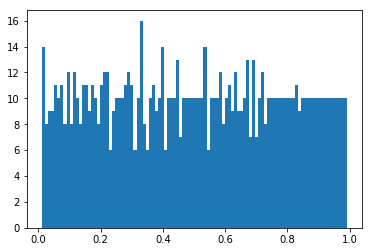

In [17]:
_ = plt.hist(
    final_datasets["trueBF"]/(final_datasets["trueBF"] + 1), bins = 100)

## Now run the above stuff on this dataset: 

In [18]:
%%time 
datasets_summary_final = estimate_BF_given_reference_table(res, final_datasets, quantile=0.0025)

Number of simulations that are retained from the reference table: 75.0
CPU times: user 10.9 s, sys: 1.01 s, total: 11.9 s
Wall time: 9.57 s


#### nice plot: 

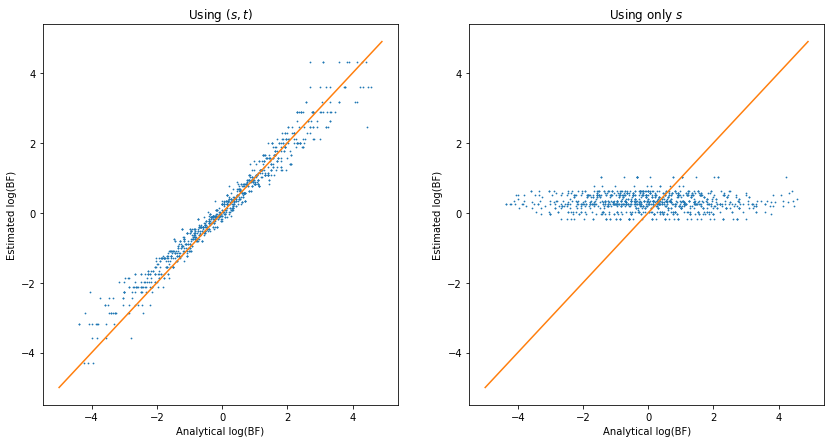

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))

x = np.arange(-5, 5, 0.1)

ax[0].plot(np.log(datasets_summary_final["trueBF"]), np.log(datasets_summary_final["appr_BF_all_stats"]), ".", 
           markersize=1.5)
ax[0].plot(x, x)
ax[0].set_title(r"Using $(s,t)$")
ax[0].set_xlabel("Analytical log(BF)")
ax[0].set_ylabel("Estimated log(BF)")

ax[1].plot(np.log(datasets_summary_final["trueBF"]), np.log(datasets_summary_final["appr_BF_1_stat"]), ".", 
          markersize=1.5)
ax[1].plot(x, x)
ax[1].set_title(r"Using only $s$")
ax[1].set_xlabel("Analytical log(BF)")
ax[1].set_ylabel("Estimated log(BF)")

#plt.savefig("Estimated_vs_analytical_BF.pdf")
plt.show()
